In [241]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

plt.style.use("ggplot")

pd.set_option('display.max_columns', None)

In [242]:
df=pd.read_csv("../raw_data/trainset_full.csv", low_memory=False)

In [243]:

X_train=df[['index', 'turbine_id', 'measured_at', 'wind_speed', 'power',
       'nacelle_direction', 'wind_direction', 'rotor_speed', 'generator_speed',
       'temp_environment', 'temp_hydraulic_oil', 'temp_gear_bearing', 'cosphi',
       'blade_angle_avg', 'hydraulic_pressure', 'park_id']]
y_train=df.Error
y_train_full=df.error_category

In [297]:
import datetime as dt
df["measured_at"]=pd.to_datetime(df.measured_at)
df["week"]=np.int64(df.measured_at.dt.isocalendar().week)


df["isweek14"]=df.week == 14
df["isweek13"] = df.week ==13
df["isweek5737"]= (df.week == 5) | (df.week == 7) | (df.week == 37)
df["isweek293031"]=(df.week == 29) | (df.week==30) | (df.week == 31)
df["highweek"]= (df.week == 14) | (df.week ==13) | (df.week == 5) | (df.week == 7) | (df.week == 37) | (df.week == 29) | (df.week==30) | (df.week == 31)
df["month"]=df.measured_at.dt.month
df["bimonth"]=df.month// 2 
df["bimonthpark"]= str(df.bimonth)+":"+str(df.park_id)
df["hourofday"]=df.measured_at.dt.hour
df["isnight"]=(df.hourofday >= 18) | (df.hourofday <=5)
df["isnoon"]=(df.hourofday >= 7) & (df.hourofday<=14)

df["Error"]=df.error_category != "NO_ERROR"

df["speed"]=(df.rotor_speed+df.generator_speed)
df["direction"]=(df.nacelle_direction+df.wind_direction)



index                               int64
turbine_id                          int64
measured_at           datetime64[ns, UTC]
wind_speed                        float64
power                             float64
nacelle_direction                 float64
wind_direction                    float64
rotor_speed                       float64
generator_speed                   float64
temp_environment                    int64
temp_hydraulic_oil                  int64
temp_gear_bearing                   int64
cosphi                            float64
blade_angle_avg                   float64
hydraulic_pressure                float64
park_id                             int64
error_category                     object
Error                                bool
week                                int64
month                               int64
bimonth                             int64
bimonthpark                        object
hourofday                           int64
isnight                           

In [271]:
num_attribs=['speed', 'power','month',
       'direction', 'rotor_speed', 'generator_speed','wind_speed',
       'temp_environment', 'temp_hydraulic_oil', 'temp_gear_bearing', 'cosphi',
       'blade_angle_avg', 'hydraulic_pressure']
cat_attribs=['park_id','bimonthpark','bimonth','turbine_id','isnight','highweek']

In [272]:
print(df.measured_at.min())
print(df.measured_at.max())
print(df.measured_at.max()-df.measured_at.min())

2019-01-01 00:00:00+00:00
2021-04-30 22:50:00+00:00
850 days 22:50:00


In [273]:
df_train=df[df.measured_at < pd.Timestamp("2020-04-29", tz="Europe/Brussels")]
df_test=df[df.measured_at >=pd.Timestamp("2020-04-29", tz="Europe/Brussels") ]

In [274]:

X_train=df_train.copy()
X_test=df_test.copy()
y_train=df_train.Error.copy()
y_test=df_test.Error.copy()
y_test_full=df_test.error_category
y_train_full=df_train.error_category

In [275]:
from sklearn.preprocessing import OneHotEncoder

encoder=OneHotEncoder(sparse=False, drop="first")
encoder.fit(X_train[cat_attribs])
encoded_cols=list(encoder.get_feature_names_out(cat_attribs))
X_train[encoded_cols]=encoder.transform(X_train[cat_attribs])
X_test[encoded_cols]=encoder.transform(X_test[cat_attribs])

In [276]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaler.fit(X_train[num_attribs])
X_train[num_attribs]=scaler.transform(X_train[num_attribs])
X_test[num_attribs]=scaler.transform(X_test[num_attribs])

In [277]:
#train a lasso and/or elastic model with logistic regression, using CV 

#the cv in glum for binomial is done (presumably) via deviance and not accuracy, but small deviance => good accuracy in principle
from glum import GeneralizedLinearRegressorCV

lin_reg=GeneralizedLinearRegressorCV(family="binomial", link="logit", cv=5, 
                                     min_alpha=0.0001, l1_ratio=[0.5,0.8, 0.9,1], 
                                     fit_intercept=True,
                                     max_iter=150)

lin_reg.fit(X_train[num_attribs+encoded_cols],y_train)

/Users/mloeffler/opt/anaconda3/lib/python3.8/site-packages/glum/_link.py:259: UserWarning: Computing sigmoid function gave results too close to 0 or 1. Clipping.
  warnings.warn(


GeneralizedLinearRegressorCV(cv=5, family='binomial',
                             l1_ratio=[0.5, 0.8, 0.9, 1], link='logit',
                             max_iter=150, min_alpha=0.0001)

In [278]:
print("alpha:", lin_reg.alpha_ ,", l1_ratio:", lin_reg.l1_ratio_)

alpha: 0.002069948461195031 , l1_ratio: 0.8


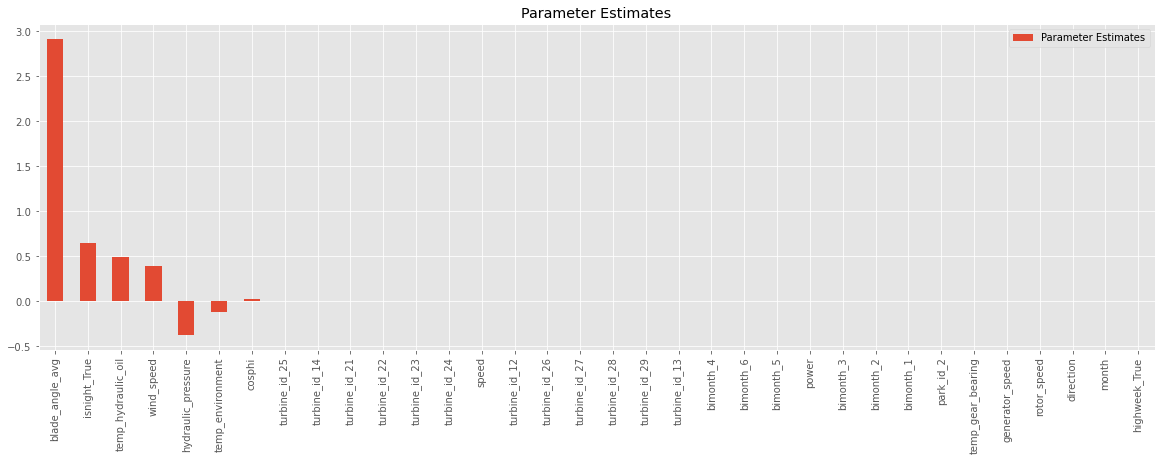

In [279]:
#plot the largest coefficients

coefs=pd.DataFrame(lin_reg.coef_, index=X_test[num_attribs+encoded_cols].columns,columns=["Parameter Estimates"])
coefs.sort_values(by="Parameter Estimates",key=abs,ascending=False).plot(kind="bar",figsize=(20,6));
plt.title("Parameter Estimates");

In [280]:
#Baseline accuracy by always guessing no error:
print("The Baseline error is:",round(np.sum(y_test)/len(y_test)*100,2), "%")


The Baseline error is: 7.2 %


In [281]:
y_hat_test=(lin_reg.predict(X_test[num_attribs+encoded_cols])>=0.5)
from sklearn.metrics import accuracy_score
print("Accuracy is", round(accuracy_score(y_hat_test,y_test)*100,2), "%", )

Accuracy is 98.81 %


In [282]:
y_baseline=np.zeros(len(y_test))

from sklearn.metrics import f1_score

print("F1 score of baseline is", f1_score(y_test,y_baseline))
print("F1 score of glm lasso is", f1_score(y_test,y_hat_test))



F1 score of baseline is 0.0
F1 score of glm lasso is 0.9120972083365377


In [300]:
#now fit xgboost



df_train.columns

Index(['index', 'turbine_id', 'measured_at', 'wind_speed', 'power',
       'nacelle_direction', 'wind_direction', 'rotor_speed', 'generator_speed',
       'temp_environment', 'temp_hydraulic_oil', 'temp_gear_bearing', 'cosphi',
       'blade_angle_avg', 'hydraulic_pressure', 'park_id', 'error_category',
       'Error', 'week', 'month', 'bimonth', 'bimonthpark', 'hourofday',
       'isnight', 'isnoon', 'speed', 'direction', 'isweek14', 'isweek13',
       'isweek5737', 'isweek293031', 'highweek'],
      dtype='object')

In [301]:
xgb_attribs=['turbine_id', 'wind_speed', 'power','week',
       'temp_environment', 'temp_hydraulic_oil', 'temp_gear_bearing', 'cosphi',
       'blade_angle_avg', 'hydraulic_pressure', 'park_id', 'month', 'speed', 'direction','isnight', 'isnoon']


In [302]:


#ordinal encode labels
from sklearn.preprocessing import LabelEncoder

labelencoder=LabelEncoder()
labelencoder.fit(df.error_category)
df["EncodedErrors"]=labelencoder.transform(df.error_category)


In [303]:
from sklearn.model_selection import train_test_split

X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb=train_test_split(df[xgb_attribs], df.EncodedErrors)

In [304]:
unique, counts = np.unique(y_train_xgb, return_counts=True)

print(np.asarray((unique, counts)).T)

[[     0  35904]
 [     1  16268]
 [     2   2816]
 [     3    582]
 [     4    103]
 [     5      2]
 [     6   1343]
 [     7     72]
 [     8     17]
 [     9   1138]
 [    10      4]
 [    11   7623]
 [    12    303]
 [    13    364]
 [    14   3629]
 [    15     22]
 [    16    821]
 [    17 954381]]


In [305]:
unique, counts = np.unique(y_test_full_trans, return_counts=True)

print(np.asarray((unique, counts)).T)

[[     0  22129]
 [     1  15507]
 [     2   1924]
 [     3    371]
 [     4     78]
 [     5      2]
 [     6    860]
 [     8      8]
 [     9    623]
 [    10      4]
 [    11   3331]
 [    12    173]
 [    13    260]
 [    14   2235]
 [    16   1081]
 [    17 626420]]


In [306]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

xgb=XGBClassifier(objective="multi:softmax",use_label_encoder=False)
parameters={"n_estimators":[100], "learning_rate":[0.1], "max_depth":[6], "gamma":[0.1]}

xgb_cv=GridSearchCV(xgb, parameters, scoring="accuracy",cv=2)
xgb_cv.fit(X_train_xgb,y_train_xgb)

print("Best parameters:", xgb_cv.best_params_ , ", Best CV Accuracy:", xgb_cv.best_score_)

[20:31:09] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [ ]:
#prediction
y_hat_xgb=xgb_cv.best_estimator_.predict(X_test_xgb)
print("XGBC has test accuracy", round(100*(accuracy_score(y_hat_xgb,y_test_xgb)),2), "%")

XGBC has test accuracy 99.37 %


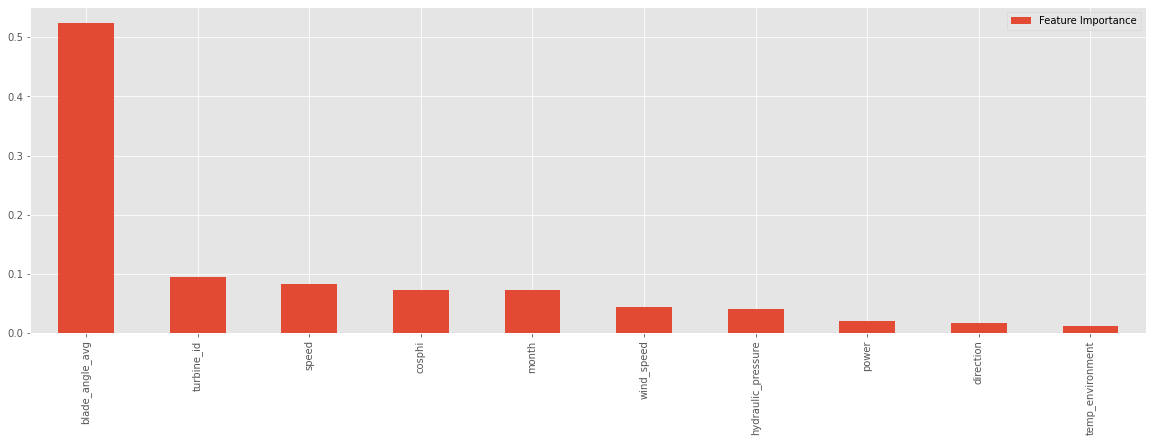

In [ ]:
#plot feature importance of xgb
importance_df=pd.DataFrame(xgb_cv.best_estimator_.feature_importances_, 
                           index=X_train_xgb.columns, columns=["Feature Importance"])

importance_df.sort_values(by="Feature Importance", ascending=False).head(10).plot(kind="bar",figsize=(20,6));

In [ ]:
y_baseline=np.zeros(len(y_test_xgb))

from sklearn.metrics import f1_score

print("F1 score of baseline is", f1_score(y_test_xgb,y_baseline, average="macro"))
print("F1 score of xgb is", f1_score(y_test_xgb,y_hat_xgb, average="macro"))



F1 score of baseline is 0.003924097297915976
F1 score of xgb is 0.785506106903474
